In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import scipy
import numpy as np
#import matplotlib.colors
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from epi.models import Parameter, Model
from epi.normalizing_flows import NormalizingFlow
from epi.util import pairplot, AugLagHPs
from epi.example_eps import V1_dr_eps, V1_all_dr_eps

neuron_inds = {'E':0, 'P':1, 'S':2, 'V':3}

In [2]:
D = 4
lb = -5.*np.ones((D,))
ub = 5.*np.ones((D,))

dh = Parameter("dh", D, lb=lb, ub=ub)
parameters = [dh]

black = np.array([0, 0, 0])
blue = '#4769A0'
red = '#AF3A31'
green = '#287C5A'
colors = [black, blue, red, green]

In [3]:
# Define model
name = "V1_Circuit"
model = Model(name, parameters)

In [4]:
npzfile = np.load('SVflip_hs.npz')
h = npzfile['b_cross']

In [5]:
from epi.example_eps import euler_sim, euler_sim_traj
import tensorflow as tf

X_INIT = tf.constant(np.random.normal(1.0, 0.01, (1, 4, 1)).astype(np.float32))

def V1_all_dr_eps(inc_val, sigma_eps=0.1, h=np.array([1., 1., 1., 1.25])):

    h = tf.constant(h[None,:,None], dtype=tf.float32)
    print('h', h)

    def dr(dh):
        dh = dh[:, :, None]

        n = 2.
        dt = 0.005
        T = 100
        tau = 0.02

        _x_shape = tf.ones_like(dh, dtype=tf.float32)
        x_init = _x_shape*X_INIT

        npzfile = np.load("data/V1_Zs.npz")
        _W = npzfile["Z_allen_square"][None, :, :]
        _W[:, :, 1:] = -_W[:, :, 1:]
        W = tf.constant(_W, dtype=tf.float32)

        def f1(y):
            omega = tf.random.normal(y.shape, 0., 1.)
            noise = sigma_eps*omega
            return (-y + (tf.nn.relu(tf.matmul(W, y) + h + noise) ** n)) / tau

        def f2(y):
            omega = tf.random.normal(y.shape, 0., 1.)
            noise = sigma_eps*omega
            return (-y + (tf.nn.relu(tf.matmul(W, y) + h + dh + noise) ** n)) / tau

        x1 = euler_sim(f1, x_init, dt, T)
        x2 = euler_sim(f2, x_init, dt, T)

        diff = x2 - x1
        T_x = tf.concat((diff, (diff - inc_val) ** 2), axis=1)

        return T_x
    return dr



In [6]:
purple = '#4C0099'
figdir = "/Users/seanbittner/Documents/epi/written/V1_model/figs/FigSX/"

def plot_T_x(T_x, T_x_sim, bins=30, xmin=None, xmax=None, xlabel=None, ylim=None, fontsize=14):
    if xmin is not None and xmax is not None:
        _range = (xmin, xmax)
    else:
        _range = None
    plt.figure()
    if T_x is None:
        plt.hist(T_x_sim, bins=bins, range=_range, color=purple, alpha=0.5)
    else:
        n, bins, patches = plt.hist(T_x, bins=bins, color='k', range=_range, alpha=0.5)
        plt.hist(T_x_sim, bins=bins, color=purple, alpha=0.5)
    if ylim is not None:
        plt.ylim(ylim)
    if xlabel is not None:
        plt.xlabel(xlabel, fontsize=fontsize)
    plt.ylabel('count', fontsize=fontsize)
    return None

h tf.Tensor(
[[[1.9435871]
  [2.8244133]
  [1.3598033]
  [1.9479313]]], shape=(1, 4, 1), dtype=float32)
E: 1 2536/500
P: 1 1581/500
S: 1 985/500
V: 1 945/500
h tf.Tensor(
[[[1.9435871]
  [2.8244133]
  [1.3598033]
  [1.9479313]]], shape=(1, 4, 1), dtype=float32)
E: 1 3531/500
P: 1 1536/500
S: 1 1212/500
V: 1 1422/500
h tf.Tensor(
[[[1.9435871]
  [2.8244133]
  [1.3598033]
  [1.9479313]]], shape=(1, 4, 1), dtype=float32)
E: 1 4333/500
P: 1 1607/500
S: 1 1733/500
V: 1 2619/500


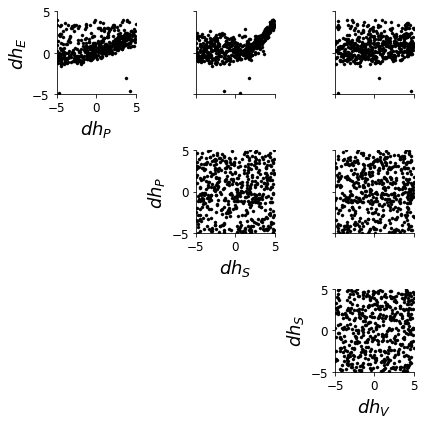

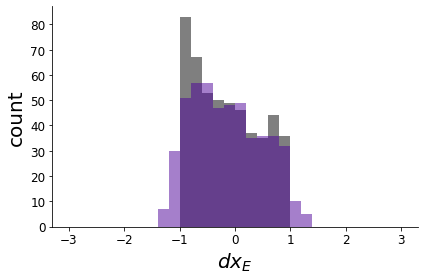

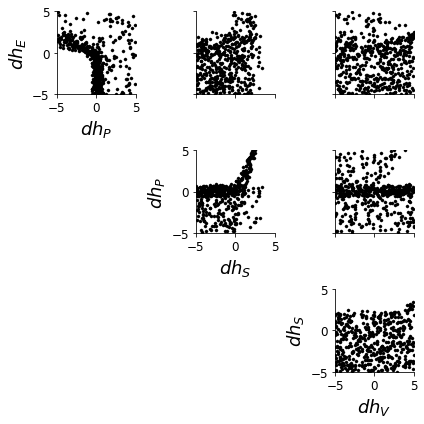

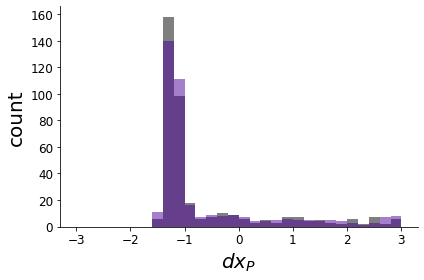

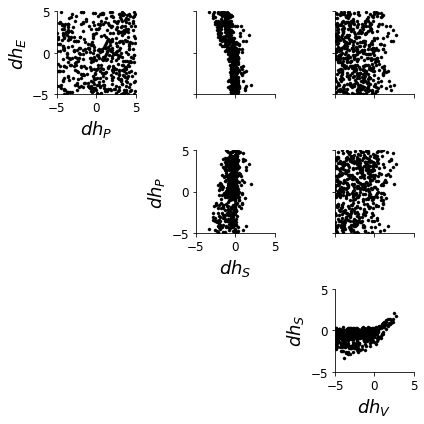

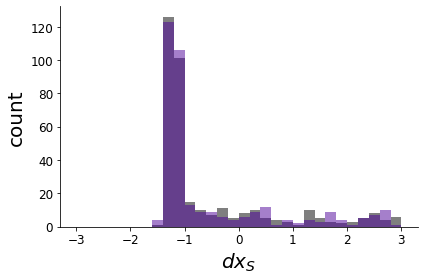

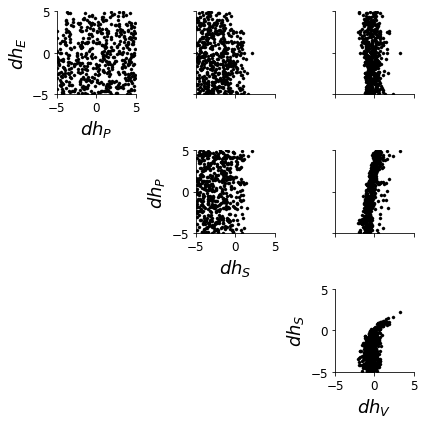

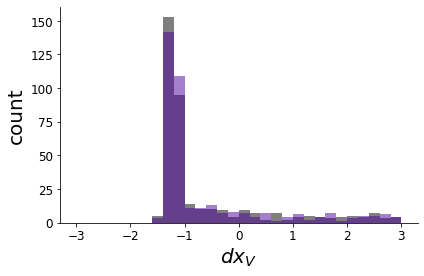

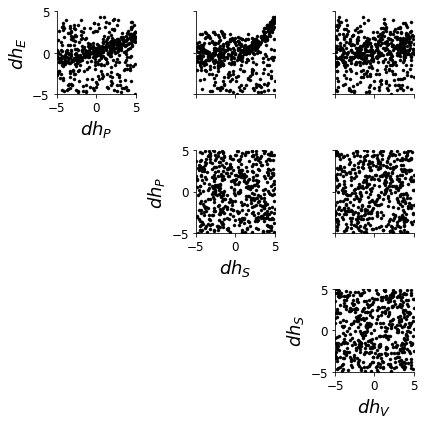

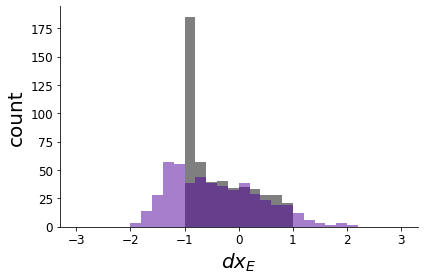

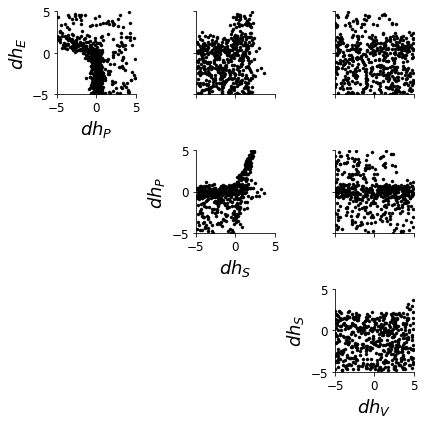

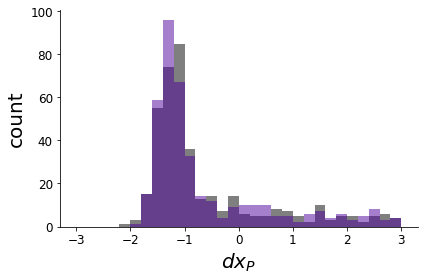

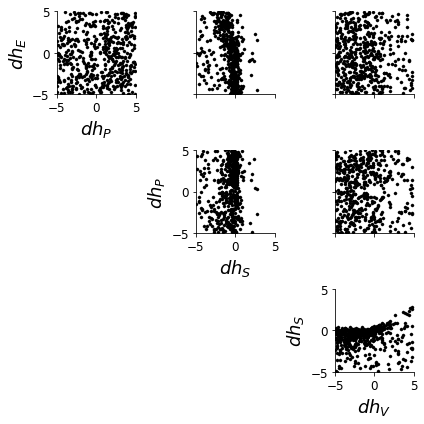

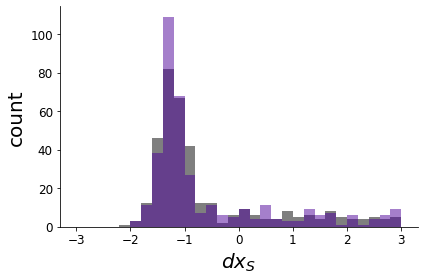

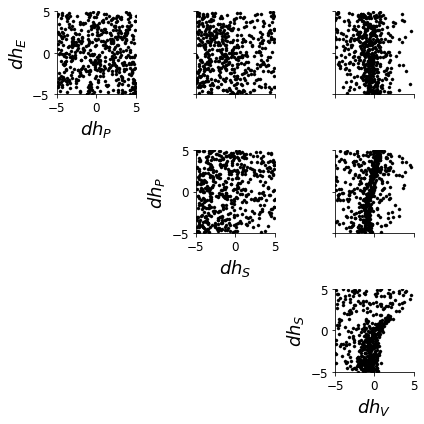

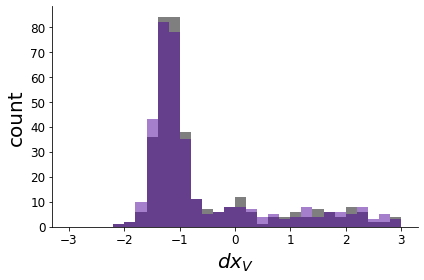

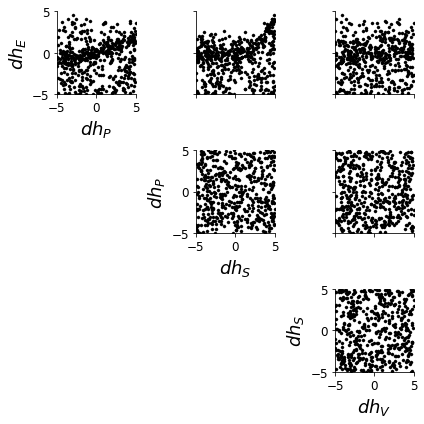

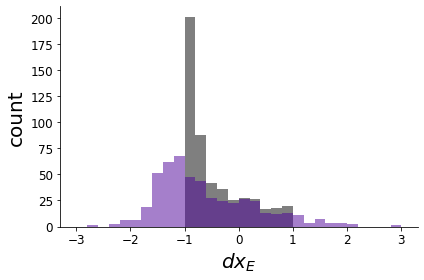

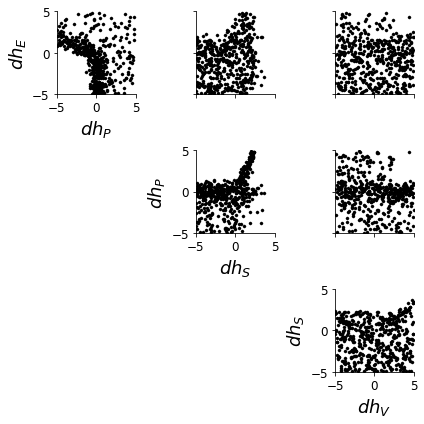

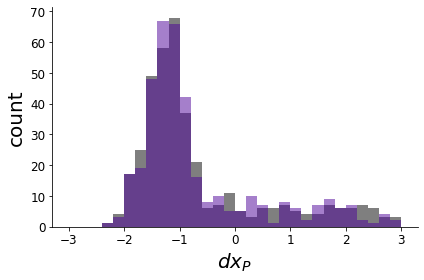

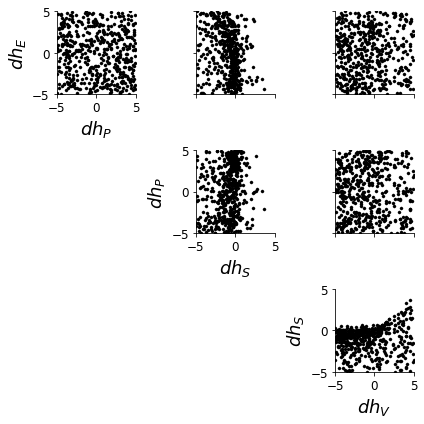

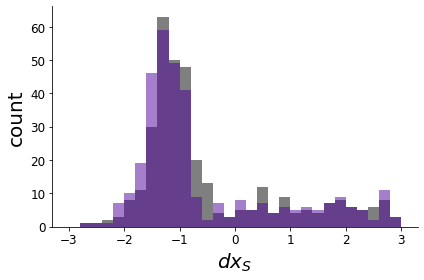

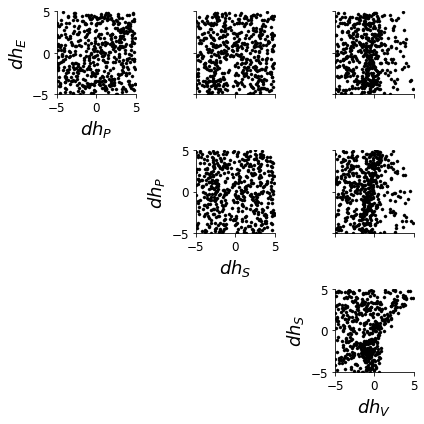

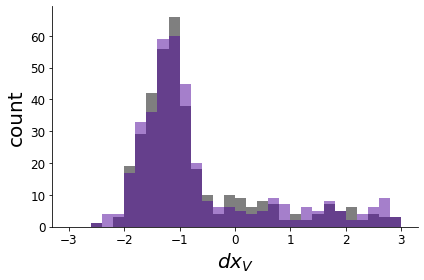

In [13]:
inc_val = 0.0


neuron_inds = {'E':0, 'P':1, 'S':2, 'V':3}
def accept_inds(T_x, alpha, inc_val, inc_std):
    neuron_ind = neuron_inds[alpha]
    return np.logical_and(inc_val-2*inc_std < T_x[:,neuron_ind], 
                          T_x[:,neuron_ind] < inc_val+2*inc_std)


alphas = ['E', 'P', 'S', 'V']
num_alphas = len(alphas)
num_keep = int(5e2)
num_plot = int(5e2)
M = 20000
zs = []
T_xs = []

inc_std = 0.5
sigma_epss = [0.1, 0.25, 0.4]


for sigma_eps in sigma_epss:
    dr_all = V1_all_dr_eps(inc_val, sigma_eps=sigma_eps, h=h[0])
    model.set_eps(dr_all)
    zs_i = []
    T_xs_i = []
    for i in range(num_alphas):
        alpha = alphas[i]
        name = "V1_Circuit_%s_eps=%.2f" % (alpha, sigma_eps)
        #M = Ms[k][i]
        neuron_ind = neuron_inds[alpha]
        fontsize = 30

        num_found = 0
        z = None
        T_x = None
        count = 0
        while (num_found < num_keep):
            count += 1
            _z = np.zeros((M, D))
            for j in range(D):
                _z[:,j] = np.random.uniform(lb[j], ub[j], (M,))
            _T_x = model.eps(_z).numpy()

            inds = accept_inds(_T_x, alpha, inc_val, inc_std)
            _z = _z[inds, :]
            _T_x = _T_x[inds, :]
            num_found += _z.shape[0]
            
            if (z is None):
                z = _z
                T_x = _T_x
            else:
                z = np.concatenate((z, _z), axis=0)
                T_x = np.concatenate((T_x, _T_x), axis=0)
            print('%s: %d %d/%d\r' % (alpha, count, num_found, num_keep), end='')

        num_found = z.shape[0]
        
        # reduce to num_keep
        z = z[:num_keep]
        T_x = T_x[:num_keep]
        zs_i.append(z)
        T_xs_i.append(T_x)

        negd = -np.square(T_x[:,neuron_ind])
        z_labels = [r'$dh_E$', r'$dh_P$', r'$dh_S$', r'$dh_V$']
        fig = pairplot(z[:num_plot], np.arange(4), z_labels, figsize=(6,6),
                       fontsize=18, lb=lb, ub=ub)
        plt.tight_layout()
        plt.savefig(figdir + name + '_ABC_z.png')
        
        T_x_sim = model.eps(z).numpy()
        
        plot_T_x(T_x[:,0], T_x_sim[:,0], xmin=-3., xmax=3., xlabel=r'$dx_%s$' % alpha, fontsize=20)
        plt.tight_layout()
        plt.savefig(figdir + name + '_ABC_Tx.png')
        print('')
        
    
    zs.append(zs_i)
    T_xs.append(T_xs_i)